In [1]:
import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import glob
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint# early stopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model # basic class for specifying and training a neural network

import mlflow

2024-10-01 17:23:02.780554: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 17:23:02.787320: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 17:23:02.808066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 17:23:02.839958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 17:23:02.849089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 17:23:02.870912: I tensorflow/core/platform/cpu_feature_gu

# Classifying teeth to M, P, I, C

In [72]:
base_model_path = '/home/riikoro/thesis/code/pretrained_base_models/bangla_english_handwritten_mnist.keras'
mnist_model = tf.keras.models.load_model(base_model_path)

In [25]:
# get from v3 all that have either M P I or C as the tooth
tooth_labels = pd.read_csv('/home/riikoro/fossil_data/tooth_samples/v3/azure_labels.txt', header=None, names=['tooth'])
tooth_labels

,tooth
0,M3
1,H1
2,T2
3,M3
4,p4
...,...
227,I3
228,I4
229,I4
230,I4


In [26]:
tooth_labels = pd.read_csv('/home/riikoro/fossil_data/tooth_samples/v3/azure_labels.txt', header=None, names=['tooth'])
tooth_labels['tooth_type'] = tooth_labels['tooth'].str[0] # extract first character
del tooth_labels['tooth']
# set labels where tooth type is unexpected to nont
tooth_labels.loc[~tooth_labels['tooth_type'].isin(['m', 'p', 'i', 'c', 'M', 'P', 'I', 'C']), 'tooth_type'] = None
# uppercase all tooth type letters
tooth_labels['tooth_type'] = tooth_labels['tooth_type'].str.upper()
tooth_labels

,tooth_type
0,M
1,None
2,None
3,M
4,P
...,...
227,I
228,I
229,I
230,I


In [27]:
# drop rows where type is unknown
tooth_labels = tooth_labels.dropna()
tooth_labels

,tooth_type
0,M
3,M
4,P
5,M
7,M
...,...
227,I
228,I
229,I
230,I


### Check class balance with histogram

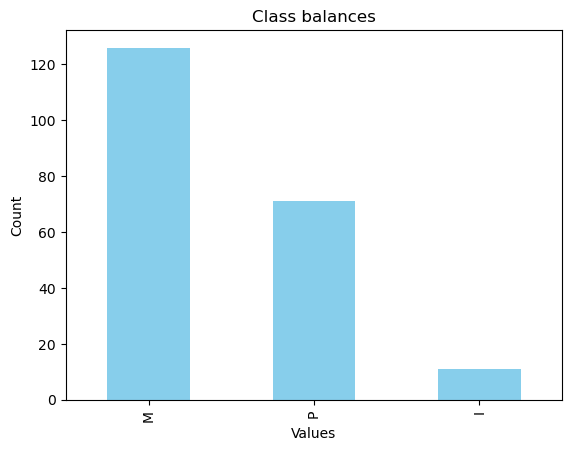

In [28]:
import matplotlib.pyplot as plt

df = tooth_labels
value_counts = df['tooth_type'].value_counts()

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Class balances')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()

In [29]:
# get fraction of most frequent class
fraction = (tooth_labels['tooth_type'] == 'M').astype('int').sum() / tooth_labels.size
fraction

0.6057692307692307

-> do only MPI classification until we get C samples

In [30]:
for layer in mnist_model.layers[:-1]:
    layer.trainable = False

new_output = Dense(3, activation='softmax')(mnist_model.layers[-2].output)
new_model = Model(mnist_model.input, new_output)
new_model.layers

[<InputLayer name=input_layer_4, built=True>,
 <Conv2D name=conv2d_16, built=True>,
 <Conv2D name=conv2d_17, built=True>,
 <MaxPooling2D name=max_pooling2d_8, built=True>,
 <Dropout name=dropout_12, built=True>,
 <Conv2D name=conv2d_18, built=True>,
 <Conv2D name=conv2d_19, built=True>,
 <MaxPooling2D name=max_pooling2d_9, built=True>,
 <Dropout name=dropout_13, built=True>,
 <Flatten name=flatten_4, built=True>,
 <Dense name=dense_8, built=True>,
 <Dropout name=dropout_14, built=True>,
 <Dense name=dense_1, built=True>]

In [31]:
for layer in new_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
True


In [57]:
def preprocess_img(image: np.array):
    image = image[:,:-12] #remove side pixels to get rid of number
    resized = cv2.resize(image,(28,28))
    colorflipped = 255-resized
    return colorflipped

In [33]:
original_images = glob.glob("/home/riikoro/fossil_data/tooth_samples/v3/*.png")

In [34]:
# convert teeth to images of shape 28x28, black and white
tooth_images = []
for i, filename in enumerate(original_images):
    img_index = int(filename.split('/')[-1].split('.')[0])
    if img_index in tooth_labels.index:
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        tooth_images.append(preprocess_img(image))

teeth = np.array(tooth_images)
teeth = teeth.reshape(teeth.shape[0], teeth.shape[1], teeth.shape[2], 1) # add rgb dimension, required by model
teeth.shape

(208, 28, 28, 1)

In [35]:
# convert labels dataframe to have m p i vector instead of letter
labels = pd.DataFrame()
labels['m'] = (tooth_labels['tooth_type'] == 'M').astype('int')
labels['p'] = (tooth_labels['tooth_type'] == 'P').astype('int')
labels['i'] = (tooth_labels['tooth_type'] == 'I').astype('int')
labels

,m,p,i
0,1,0,0
3,1,0,0
4,0,1,0
5,1,0,0
7,1,0,0
...,...,...,...
227,0,0,1
228,0,0,1
229,0,0,1
230,0,0,1


In [36]:

X_train, X_val, Y_train, Y_val = train_test_split(teeth, labels, test_size = 0.1, random_state=2)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(187, 28, 28, 1) (21, 28, 28, 1) (187, 3) (21, 3)


In [37]:
model = new_model

# steps copied from mnist classifier notebook
batch_size = 6 # in each iteration, we consider 128 training examples at once
num_epochs = 150
X_train = X_train.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False),
              # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [38]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 - 2s - 67ms/step - accuracy: 0.4144 - loss: 1.2078 - val_accuracy: 0.3810 - val_loss: 129.0264 - learning_rate: 0.0010
Epoch 2/50
31/31 - 0s - 2ms/step - accuracy: 0.3333 - loss: 1.2835 - val_accuracy: 0.3810 - val_loss: 127.8282 - learning_rate: 0.0010
Epoch 3/50


/home/riikoro/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/home/riikoro/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 - 0s - 10ms/step - accuracy: 0.4641 - loss: 1.1206 - val_accuracy: 0.4762 - val_loss: 97.0554 - learning_rate: 0.0010
Epoch 4/50
31/31 - 0s - 2ms/step - accuracy: 0.6667 - loss: 0.7844 - val_accuracy: 0.4762 - val_loss: 96.0026 - learning_rate: 0.0010
Epoch 5/50
31/31 - 0s - 12ms/step - accuracy: 0.5083 - loss: 1.0110 - val_accuracy: 0.6667 - val_loss: 88.9758 - learning_rate: 0.0010
Epoch 6/50
31/31 - 0s - 2ms/step - accuracy: 0.5000 - loss: 1.1175 - val_accuracy: 0.6667 - val_loss: 89.1368 - learning_rate: 0.0010
Epoch 7/50
31/31 - 1s - 24ms/step - accuracy: 0.4696 - loss: 0.9940 - val_accuracy: 0.7143 - val_loss: 96.9968 - learning_rate: 0.0010
Epoch 8/50
31/31 - 0s - 5ms/step - accuracy: 0.3333 - loss: 0.9828 - val_accuracy: 0.7143 - val_loss: 96.9766 - learning_rate: 0.0010
Epoch 9/50
31/31 - 1s - 25ms/step - accuracy: 0.5691 - loss: 0.9122 - val_accuracy: 0.7143 - val_loss: 97.6308 - learning_rate: 0.0010
Epoch 10/50
31/31 - 0s - 5ms/step - accuracy: 0.6667 - loss: 0.8751 -

2024-10-01 17:26:37.262874: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 - 1s - 27ms/step - accuracy: 0.5470 - loss: 0.9043 - val_accuracy: 0.6190 - val_loss: 97.8261 - learning_rate: 0.0010
Epoch 30/50
31/31 - 0s - 5ms/step - accuracy: 0.3333 - loss: 0.9440 - val_accuracy: 0.6190 - val_loss: 97.8868 - learning_rate: 0.0010
Epoch 31/50
31/31 - 1s - 25ms/step - accuracy: 0.5525 - loss: 0.9199 - val_accuracy: 0.6190 - val_loss: 94.6992 - learning_rate: 0.0010
Epoch 32/50
31/31 - 0s - 5ms/step - accuracy: 0.8333 - loss: 0.5084 - val_accuracy: 0.6190 - val_loss: 94.6709 - learning_rate: 0.0010
Epoch 33/50
31/31 - 1s - 28ms/step - accuracy: 0.5912 - loss: 0.8587 - val_accuracy: 0.6190 - val_loss: 95.2203 - learning_rate: 0.0010
Epoch 34/50
31/31 - 0s - 4ms/step - accuracy: 0.8333 - loss: 0.5051 - val_accuracy: 0.6190 - val_loss: 95.4149 - learning_rate: 0.0010
Epoch 35/50
31/31 - 1s - 27ms/step - accuracy: 0.5912 - loss: 0.8132 - val_accuracy: 0.6190 - val_loss: 97.5086 - learning_rate: 0.0010
Epoch 36/50
31/31 - 0s - 5ms/step - accuracy: 0.6667 - loss: 1.

[0.7662632465362549, 0.6203208565711975]

In [74]:
loss, acc = model.evaluate(X_train, Y_train, verbose=1)
acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6272 - loss: 0.7706


0.6203208565711975

In [39]:
test_loss, test_acc = model.evaluate(X_val, Y_val)
test_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6667 - loss: 90.3532


0.6666666865348816

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy: 0.6666666666666666


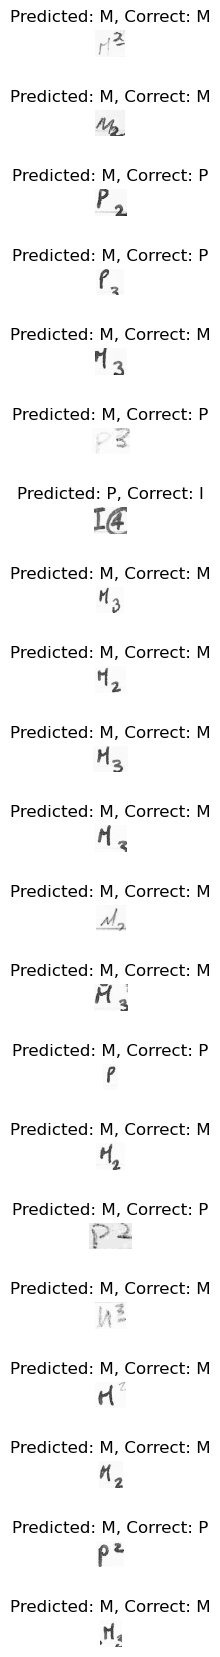

In [71]:
def id_to_tooth(id):
    if id == 0:
        return 'M'
    elif id == 1:
        return 'P'
    elif id == 2:
        return 'I'

correct = 0
test_data_size = X_val.shape[0]
fig, ax = plt.subplots(test_data_size, figsize= (200, test_data_size))
plt.subplots_adjust(hspace=2)
for i, img_i in enumerate(Y_val.index):
    image = cv2.imread(f'/home/riikoro/fossil_data/tooth_samples/v3/{img_i}.png', cv2.IMREAD_GRAYSCALE)

    label_i = Y_val.loc[img_i]
    label = id_to_tooth(np.argmax(label_i))

    preprocessed = preprocess_img(image)
    pred = model.predict(preprocessed.reshape(1,28,28,1))
    pred_tooth = id_to_tooth(np.argmax(pred))
    correct_tooth = label
    fig_title = f'Predicted: {pred_tooth}, Correct: {correct_tooth}'
    if pred_tooth == correct_tooth:
        correct += 1

    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(fig_title)

print(f'Accuracy: {correct/test_data_size}')

In [75]:
%env MLFLOW_TRACKING_URI=sqlite:///../mlflow.db
mlflow.set_experiment("MPIC")

params = {
    'data_v': 3,
    'train_size': X_train.shape[0],
    'test_size': X_val.shape[0],
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'base_model_path': base_model_path
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("most frequent class occurence fraction", fraction)
    mlflow.log_metric("training accuracy", acc)
    mlflow.log_metric("test accuracy", test_acc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "Initial test using Fort Tenan Catalogue extractions, problem: major class imbalance")

env: MLFLOW_TRACKING_URI=sqlite:///../mlflow.db
